In [1]:
import numpy as np
import os 
import sys
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt 
ispec_dir = '/home/nachi/iSpec/iSpec_v20230804/'
sys.path.insert(0, os.path.abspath(ispec_dir))
import ispec

logging.basicConfig(level=logging.CRITICAL)


#LOG_LEVEL = "info"
#logger = logging.getLogger() # root logger, common for all
#logger.setLevel(logging.getLevelName(LOG_LEVEL.upper()))

[2024-06-05 15:13:27,741] [INFO] [utils:_init_num_threads:148]: Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-06-05 15:13:27,743] [INFO] [utils:_init_num_threads:160]: NumExpr defaulting to 8 threads.


In [2]:
rvs = np.array(np.loadtxt("/home/nachi/notebooks/notebooks/galactic_arc/rvs2_new.txt"))
snrs = np.array(np.loadtxt("/home/nachi/notebooks/notebooks/galactic_arc/SNRs_new.txt"))
barycor = np.array(np.loadtxt("/home/nachi/notebooks/notebooks/galactic_arc/barycor_new.txt"))

In [4]:
def determine_radial_velocity_with_template(file_num):
    obs_spectrum = ispec.read_spectrum(f"/home/nachi/notebooks/notebooks/galactic_arc/formattedSpecs3/obs_file_{file_num}.txt.gz",nl=True)
    #logging.info("Radial velocity determination with template...")
    template = ispec.read_spectrum(f"/home/nachi/notebooks/notebooks/galactic_arc/formattedSpecs3/tmplt_file_{file_num}.txt.gz",nl=True)
    models, ccf = ispec.cross_correlate_with_template(obs_spectrum, template, \
                            lower_velocity_limit=-600, upper_velocity_limit=600, \
                            velocity_step=1.0, fourier=False)
    
    # Number of models represent the number of components
    components = len(models)
    # First component:

    if components == 0:
        rv = np.inf
        rv_err = np.inf
        return rv,rv_err
    
    rv = np.round(models[0].mu(), 2) # km/s
    rv_err = np.round(models[0].emu(), 2) # km/s
    return rv, rv_err

predicted_rvs = []
predicted_errs = []
err_idx = []
for i in tqdm(range(len(rvs))):
    pred_rv, pred_err = determine_radial_velocity_with_template(i)

    if pred_rv == np.inf:
        err_idx.append(i)
        
    predicted_rvs.append(pred_rv)
    predicted_errs.append(pred_err)

predicted_rvs = np.array(predicted_rvs)

100%|██████████| 558/558 [04:09<00:00,  2.23it/s]


In [8]:
pred_idx = [i for i in range(len(rvs)) if i not in err_idx]
np.savetxt("prevs.txt",predicted_rvs)
np.savetxt("non_err_idx.txt",pred_idx)

/tmp/ipykernel_43098/1336724270.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('inferno')


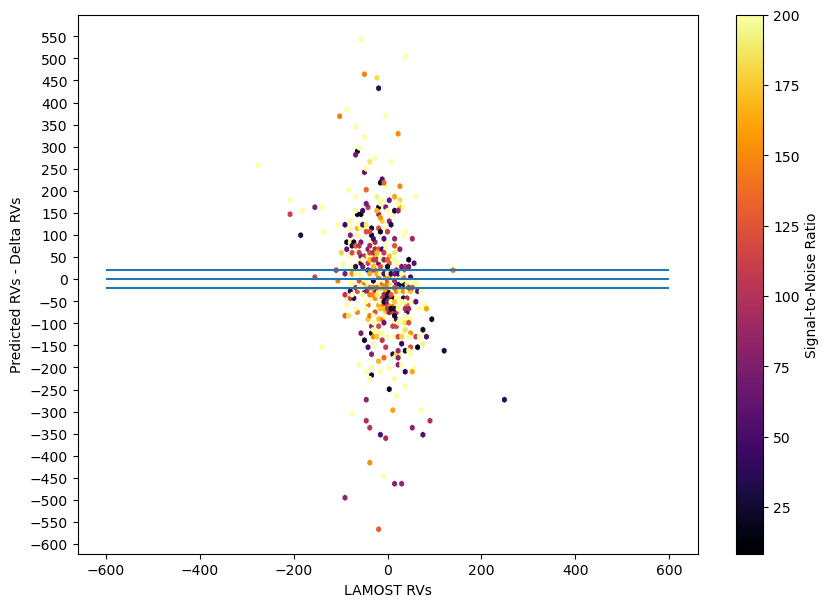

In [10]:
delta_RV =  predicted_rvs[pred_idx]- rvs[pred_idx] + barycor[pred_idx]
cmap = plt.cm.get_cmap('inferno') 

snrs_test = [i if i <= 200 else 200 for i in snrs[pred_idx]]
fig, ax = plt.subplots(figsize=(10, 7))
hex = ax.hexbin(rvs[pred_idx],delta_RV, gridsize=(70,70),C = snrs_test, cmap=cmap)
plt.colorbar(hex, label='Signal-to-Noise Ratio')
plt.xlabel("LAMOST RVs")
plt.ylabel("Predicted RVs - Delta RVs")
plt.yticks(np.arange(-650,650,50))
plt.hlines(0,-600,600)
plt.hlines(20,-600,600)
plt.hlines(-20,-600,600)
#sc = plt.scatter(np.array(rvs[pred_idx]),delta_RV,c=snrs[pred_idx],cmap=cmap)
#plt.colorbar(sc, label='Signal-to-Noise Ratio') 
plt.show()

/tmp/ipykernel_43098/1768802562.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('inferno')


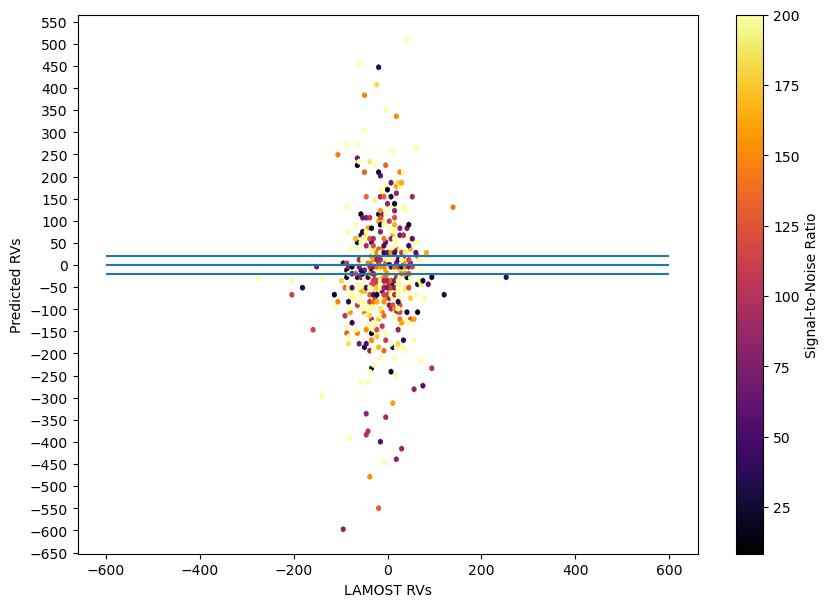

In [11]:
cmap = plt.cm.get_cmap('inferno') 

snrs_test = [i if i <= 200 else 200 for i in snrs[pred_idx]]
fig, ax = plt.subplots(figsize=(10, 7))
hex = ax.hexbin(rvs[pred_idx],predicted_rvs[pred_idx], gridsize=(70,70),C = snrs_test, cmap=cmap)
plt.colorbar(hex, label='Signal-to-Noise Ratio')
plt.xlabel("LAMOST RVs")
plt.ylabel("Predicted RVs")
plt.yticks(np.arange(-650,650,50))
plt.hlines(0,-600,600)
plt.hlines(20,-600,600)
plt.hlines(-20,-600,600)
#sc = plt.scatter(np.array(rvs[pred_idx]),delta_RV,c=snrs[pred_idx],cmap=cmap)
#plt.colorbar(sc, label='Signal-to-Noise Ratio') 
plt.show()